In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set_style("white") # seaborn 有五个主题可以设置 white是其中的一个

%matplotlib inline

In [2]:
def np2u8(image):
    return np.uint8(np.abs(image))

# 实验目的
该例的目的是说明用前述算法来寻找大小适合车牌的矩形的应用。该矩形可以通过检测强的水平和垂直边缘构成。图(b)显示了梯度幅度图像M(x，y)，图(c)和(d)显示了该算法步骤3和步骤4的结果，其中，令TM等于最大梯度值的30％，A＝90°，TA＝45°，并填充了全部25个或更少像素的缝隙(约为图像宽度的5％)。
为检测车牌壳的全部拐角和汽车的后窗，要求使用一个较大范围的容许角度方向。图(e)是前两幅图像逻辑“或”(OR)操作的结果，图(f)是使用9.5.5节讨论的细化过程细化图(e)得到的。如图(f)所示，在图像中清楚地检测到了对应于车牌的矩形。

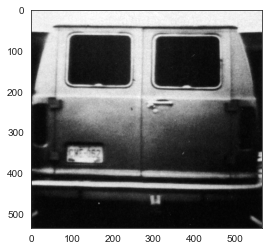

In [3]:
image_path = 'Image/exp3.tif'
image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(image,cmap = 'gray')
# plt.axis('off')
plt.show()

In [4]:
# 其实在做 LoG函数，opencv内置了sobel的梯度方法
# full same valid为三种卷积范围选择方式
gauss = np.array([[1,2,1],[2,4,2],[1,2,1]])/16
sobel_x = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
sobel_y = sobel_x.T

In [5]:
# 卷积求出原图像梯度 采用 cv2.CV_64F格式
ig = cv2.filter2D(image,cv2.CV_32F,gauss)
igx = cv2.filter2D(ig,cv2.CV_32F,sobel_x)
igy = cv2.filter2D(ig,cv2.CV_32F,sobel_y)
M = (igx**2+igy**2)**0.5

# 注意这里算相位
eps = 1e-9
alpha_d = np.divide(igy,igx+eps)  #注意作除法一定要把这个eps加上，否则divide0 error
alpha = np.arctan(alpha_d)*180/np.pi

ig = np2u8(ig)
igx = np2u8(igx)
igy = np2u8(igy)
M = np2u8(M)

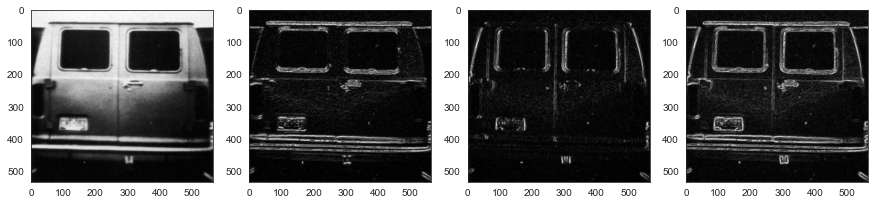

In [6]:
# 如果在前面不转换成 cv2.64f,这里就会是灰色的。
plt.figure(figsize = (15,15))
plt.subplot(141)
plt.imshow(ig,cmap = 'gray')
plt.subplot(142)
plt.imshow(igx,cmap = 'gray')
plt.subplot(143)
plt.imshow(igy,cmap = 'gray')
plt.subplot(144)
plt.imshow(M,cmap = 'gray')

In [17]:
alpha
np.max(np.max(M))
Md

array([[ 0,  0,  4, ...,  9, 12,  0],
       [ 9,  9,  9, ..., 12, 20, 17],
       [16, 15, 16, ...,  8, 16, 14],
       ...,
       [10, 14, 17, ..., 41, 40, 37],
       [ 9, 12, 16, ..., 45, 44, 45],
       [ 0,  1,  2, ..., 22, 11,  0]], dtype=uint8)

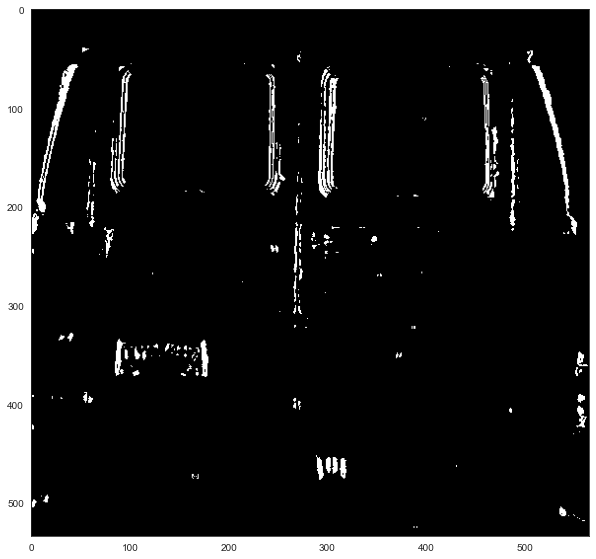

In [14]:
def binimg(M,alpha,Tm):
    bimg = np.zeros_like(M)
    (m,n) = M.shape
    for i in range(m):
        for j in range(n):
            Mpoint = M[i,j]
            dpoint  = alpha[i,j]
            if (Mpoint > Tm) & ((dpoint >= -90) & (dpoint <= -45) | (dpoint <= 90) & (dpoint >= 45)):
                bimg[i,j] = 1
    return bimg
            


                                     

Tm = np.max(np.max(M))*0.3
bimg = binimg(M,alpha,Tm)
plt.figure(figsize = (10,10))
plt.imshow(bimg,cmap = 'gray')

In [8]:
def find_one(arr, start,max_len):
    # print(max_len)
    cnt = start
    max_len = len(arr)
    cnt = start
    if(cnt >= max_len):
        return None
    while cnt < max_len & arr[cnt] != 1:
        cnt += 1
#         if(cnt >= max_len):
#             return None
    if arr[cnt] == 1:
        return cnt
    else:
        # print('None')
        return None

# 水平连接边缘像素

def scan_horizon2(g,L = 25):
    (m,n) =  g.shape
    cnt = 0
    for i in range(m):
        line = g[i,:]
        # 初始化 找到第一个front和rear
        rear = find_one(line,0,n)
        if(rear is not None):
            front = find_one(line,rear+1,n)
            if(front is not None):
                # 第一个front和rear 找到
                if front - rear < L:
                    g[i,rear:front+1] = 1
                while((rear is not None) and (front is not None)):
                    rear = front
                    # print("rear：",rear)
                    front = find_one(line,rear+1,n)
                    if((rear is not None) and (front is not None)):
                        if((front-rear < L)):
                            g[i,rear:front+1] = 1

In [10]:
# 水平连接边缘的原理
# 检测边缘： 梯度二值化之后发生突变： 1 x 0 或者 0 x 1，然后如果这两个x的距离小于K，进行填充。
def scan_horizon(img,L = 25):
    edge_flag = np.zeros_like(img)
    rem_ind = np.zeros_like(img) # 记录这一行的索引位置。
    (m,n) = img.shape
    for i in range(m):
        ind = 0
        for j in range(1,n-1):
            if img[i,j-1] != img[i,j+1]:
                edge_flag[i,j] = 1
                rem_ind[i,ind] = j
                ind += 1
    # 已经生成edge_flag
    for i in range(m):
        # 这样就不需要front和rear多余的手法
        for j in range(1,n):
            front = rem_ind[i,j]
            rear = rem_ind[i,j-1]
            if(front == 0):
                continue
            else:
                if(front -rear < L):
                    img[i,rear:front] = 1      
        

In [12]:
# 测试
arr = np.array([[1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1],
                [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1]])
scan_horizon(arr)
arr

array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1]])

<ipython-input-10-a63acc2885c0>:23: RuntimeWarning: overflow encountered in ubyte_scalars
  if(front -rear < L):


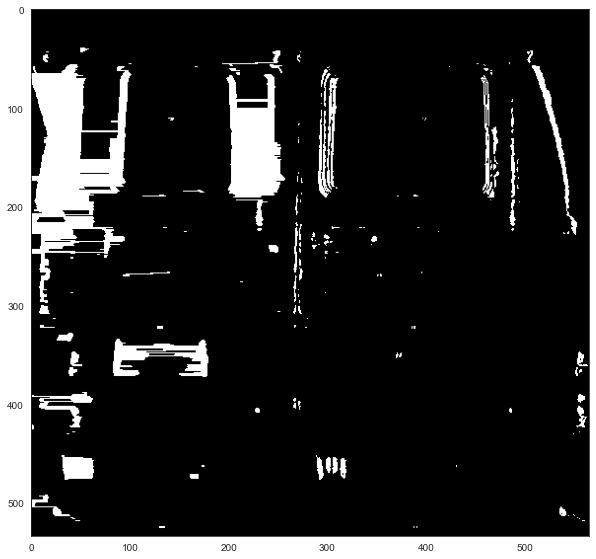

In [13]:
scan_horizon(bimg)
plt.figure(figsize = (10,10))
plt.imshow(bimg,cmap = 'gray')

In [ ]:
https://www.cnblogs.com/er-gou-zi/p/11993945.html

In [ ]:
# 转置之后进行相同的步骤，
imaget = image.T
plt.imshow(imaget,cmap = 'gray')
# plt.axis('off')
plt.show()
# 卷积求出原图像梯度 采用 cv2.CV_64F格式
igt = cv2.filter2D(imaget,cv2.CV_32F,gauss)
igxt = cv2.filter2D(igt,cv2.CV_32F,sobel_x)
igyt = cv2.filter2D(igt,cv2.CV_32F,sobel_y)
Mt = (igxt**2+igyt**2)**0.5

# 注意这里算相位
eps = 1e-9
alpha_dt = np.divide(igyt,igxt+eps)  #相位有点问题，还没有解决
alphat = np.arctan(alpha_dt)

igt = np2u8(igt)
igxt = np2u8(igxt)
igyt = np2u8(igyt)
Mt = np2u8(Mt)

igt = igt.T
igxt = igxt.T
igyt = igyt.T
Mt = Mt.T

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(141)
plt.imshow(igt,cmap = 'gray')
plt.subplot(142)
plt.imshow(igxt,cmap = 'gray')
plt.subplot(143)
plt.imshow(igyt,cmap = 'gray')
plt.subplot(144)
plt.imshow(Mt,cmap = 'gray')

# 变量浏览区

In [ ]:
alpha

In [ ]:
cv2.filter2D?